In [0]:
import os
import math

from IPython import display
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

pd.options.display.float_format = "{:.3f}".format

style.use('ggplot')

os.chdir('/content/drive/ml_directory/recommend_this/juice_recommender/')

In [66]:
my_juice_df = pd.read_csv('juices_modified_dataset.csv')
display.display(my_juice_df.head())

my_juice_df = my_juice_df.reindex(np.random.permutation(my_juice_df.index))
display.display(my_juice_df.head())

,fid,juice_name,disease_cold,disease_soarthroat,disease_fever,disease_curing
0,1,Rock The Beet,0,0,1,fever
1,2,Turmeric Sunrise,0,0,1,fever
2,3,Lemon Drop,0,0,1,fever
3,4,Fennel to the Metal,0,0,1,fever
4,5,Dragon Blood,0,0,1,fever


,fid,juice_name,disease_cold,disease_soarthroat,disease_fever,disease_curing
11,12,Strawberry-Pineapple-Mint,0,0,1,fever
61,63,Curry Green Leaf,1,0,1,cold_fever
47,49,Pick-Me-Up Egg Drop,1,0,0,cold
22,23,Watermelon,1,1,0,cold_soarthroat
0,1,Rock The Beet,0,0,1,fever


In [67]:
def category_conversion(df, series_name):
    return pd.to_numeric(pd.Categorical(df[series_name]).codes)


my_juice_df['disease_curing'] = category_conversion(my_juice_df,
                                                    "disease_curing")
display.display(my_juice_df.head())

### explicitly convert datatype of "disease_curing" column
my_juice_df['disease_curing'] = my_juice_df.disease_curing.astype('int32')
display.display(my_juice_df.head())

,fid,juice_name,disease_cold,disease_soarthroat,disease_fever,disease_curing
11,12,Strawberry-Pineapple-Mint,0,0,1,4
61,63,Curry Green Leaf,1,0,1,1
47,49,Pick-Me-Up Egg Drop,1,0,0,0
22,23,Watermelon,1,1,0,2
0,1,Rock The Beet,0,0,1,4


,fid,juice_name,disease_cold,disease_soarthroat,disease_fever,disease_curing
11,12,Strawberry-Pineapple-Mint,0,0,1,4
61,63,Curry Green Leaf,1,0,1,1
47,49,Pick-Me-Up Egg Drop,1,0,0,0
22,23,Watermelon,1,1,0,2
0,1,Rock The Beet,0,0,1,4


,fid,disease_cold,disease_soarthroat,disease_fever,disease_curing
count,65.000,65.000,65.000,65.000,65.000
mean,33.492,0.523,0.415,0.385,2.646
std,19.346,0.503,0.497,0.490,2.072
min,1.000,0.000,0.000,0.000,0.000
25%,17.000,0.000,0.000,0.000,0.000
50%,33.000,1.000,0.000,0.000,3.000
75%,50.000,1.000,1.000,1.000,4.000
max,66.000,1.000,1.000,1.000,6.000


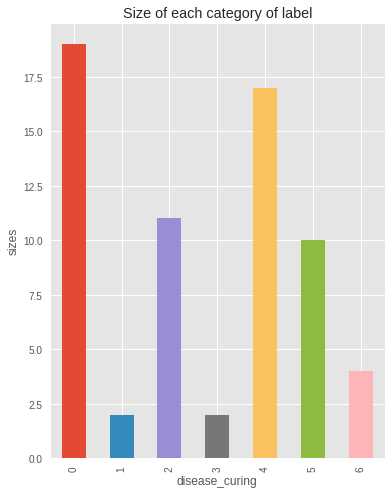

In [68]:
display.display(my_juice_df.describe())

### sizes of different labels
my_juice_df.groupby('disease_curing').size().plot(
    figsize=(6, 8), kind='bar', title="Size of each category of label")
plt.ylabel("sizes")
plt.show()

In [69]:
juice_name_array = np.array(list(my_juice_df.juice_name))

label_juice_encoder = LabelEncoder()
integer_juice_encoded = label_juice_encoder.fit_transform(juice_name_array)
print(integer_juice_encoded)
print(type(integer_juice_encoded))
integer_juice_encoded = list(integer_juice_encoded)
print(type(integer_juice_encoded))
# arraying each element
# integer_juice_encoded = integer_juice_encoded.reshape(len(integer_juice_encoded), 1)
print(len(integer_juice_encoded))

[54 12 43 63 48  3 56 11 28 19 57  5 49 10 13  0  1 35 25 34 64 38 36 50
 21 58 59 17 18 53 20 60 47 39 62  2  7 40 41 26 22 27  9 61 44  8  6 14
 15 52 23 30 55 24 37 29  4 46 33 32 31 16 42 51 45]
<class 'numpy.ndarray'>
<class 'list'>
65


In [70]:
my_juice_df["juice_encoded"] = integer_juice_encoded
display.display(my_juice_df.head())

,fid,juice_name,disease_cold,disease_soarthroat,disease_fever,disease_curing,juice_encoded
11,12,Strawberry-Pineapple-Mint,0,0,1,4,54
61,63,Curry Green Leaf,1,0,1,1,12
47,49,Pick-Me-Up Egg Drop,1,0,0,0,43
22,23,Watermelon,1,1,0,2,63
0,1,Rock The Beet,0,0,1,4,48


In [0]:
def preprocess_features(dataframe):
    features = [
        "juice_encoded", "disease_cold", "disease_soarthroat", "disease_fever"
    ]
    selected_features = dataframe[features]
    processed_features = selected_features.copy()
    return processed_features


def preprocess_targets(dataframe):
    output_targets = pd.DataFrame()
    output_targets["disease_curing"] = dataframe["disease_curing"]
    return output_targets

In [118]:
training_examples = preprocess_features(my_juice_df[0:])
training_targets = preprocess_targets(my_juice_df[0:])
display.display(training_examples.head())
display.display(training_targets.head())

,juice_encoded,disease_cold,disease_soarthroat,disease_fever
11,54,0,0,1
61,12,1,0,1
47,43,1,0,0
22,63,1,1,0
0,48,0,0,1


,disease_curing
11,4
61,1
47,0
22,2
0,4


In [0]:
def construct_feature_columns(input_features):
    return set([
        tf.feature_column.numeric_column(my_feature)
        for my_feature in input_features
    ])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True,
                num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=50)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_classification_model(my_optimizer, batch_size, steps,
                                  hidden_units, training_examples,
                                  training_targets):
    periods = 10
    steps_per_period = steps / periods

    ### create and configure optimizer
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(
        my_optimizer, 5.0)

    dnn_classifier = tf.estimator.DNNClassifier(
        feature_columns=construct_feature_columns(training_examples),
        n_classes=7,
        hidden_units=hidden_units,
        optimizer=my_optimizer)

    ### create input_fn
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["disease_curing"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets['disease_curing'],
                                                    shuffle=False,
                                                    num_epochs=1)

    ### train the model
    print("Training the model...")
    print("  LogLoss error (on training data):")
    training_log_loss = []

    for period in range(0, periods):
        dnn_classifier.train(
            input_fn=training_input_fn, steps=steps_per_period)

        training_predictions = list(
            dnn_classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array(
            [item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array(
            [item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(
            training_pred_class_id, 7)

        training_loss_each_step = metrics.log_loss(training_targets,
                                                   training_pred_one_hot)

        print("    Period {:02d} : {:.7f}".format(period,
                                                  training_loss_each_step))
        training_log_loss.append(training_loss_each_step)
    print("Model training finished.")

    final_predictions = dnn_classifier.predict(
        input_fn=predict_training_input_fn)
    final_predictions = np.array(
        [item['class_ids'][0] for item in final_predictions])

    accuracy = metrics.accuracy_score(training_targets, final_predictions)
    print("\nFinal accuacy (on training) data : {:.4f}".format(accuracy))

    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_loss, label="training loss", color="magenta")
    plt.legend()
    plt.show()
    return dnn_classifier

Training the model...
  LogLoss error (on training data):
    Period 00 : 24.4428264
    Period 01 : 24.4428264
    Period 02 : 24.4428264
    Period 03 : 23.9114606
    Period 04 : 23.9114606
    Period 05 : 22.3173632
    Period 06 : 22.8487290
    Period 07 : 21.7859974
    Period 08 : 22.3173632
    Period 09 : 22.8487290
Model training finished.

Final accuacy (on training) data : 0.3385


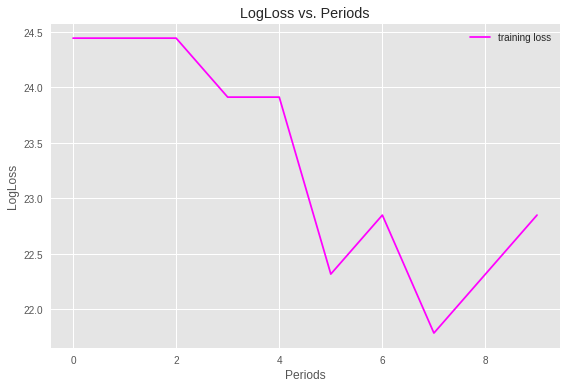

In [176]:
dnn_classofier = train_nn_classification_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.007),
    batch_size=3,
    steps=500,
    hidden_units=[3, 4, 5, 6],
    training_examples=training_examples,
    training_targets=training_targets)